# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:05<00:00, 11.3KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

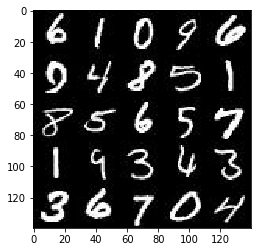

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

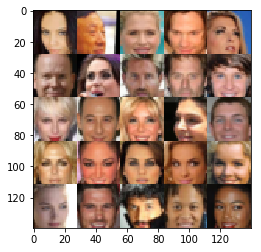

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
     # TODO: Implement Function
    #n_units = 128
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        # strides = 2 #if layer_depth % 3 == 0 else 1
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', activation=None)
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(images, 256, 5, strides=2, padding='same', activation=None)
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flatten = tf.contrib.layers.flatten(h3)
        logits = tf.layers.dense(flatten, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    #n_units = 128
    alpha = 0.2
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        #print(x1.shape.as_list())

        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape.as_list())
        # 14x14x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape.as_list())
        # 28x28x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x5 now
        
        out = tf.tanh(logits)
        #print(out.shape.as_list())
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, show_every = 100, print_every = 100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_inputs, fake_inputs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, fake_inputs, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    samples, losses = [], []
    steps = 0
    
    #print_every = 50
    #show_every = 200
    n_img_show = 16
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = 2.0 * batch_images
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, 
                             feed_dict={real_inputs: batch_images, fake_inputs: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, 
                             feed_dict={real_inputs: batch_images, fake_inputs: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_inputs: batch_images, fake_inputs: batch_z})
                    train_loss_g = g_loss.eval({fake_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_img_show, fake_inputs, data_shape[3], data_image_mode)
            show_generator_output(sess, n_img_show, fake_inputs, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5373... Generator Loss: 2.3170


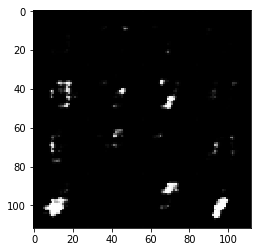

Epoch 1/2... Discriminator Loss: 1.8754... Generator Loss: 0.2371


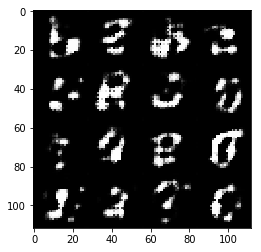

Epoch 1/2... Discriminator Loss: 2.2866... Generator Loss: 2.0966


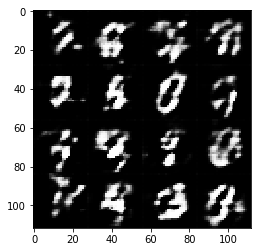

Epoch 1/2... Discriminator Loss: 1.7126... Generator Loss: 2.2152


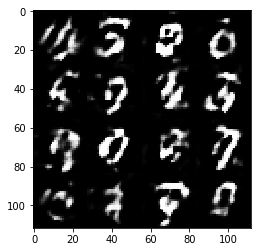

Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 1.6741


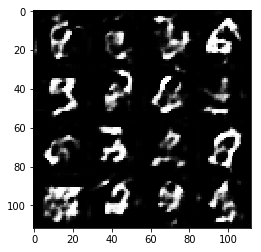

Epoch 1/2... Discriminator Loss: 1.6990... Generator Loss: 1.7593


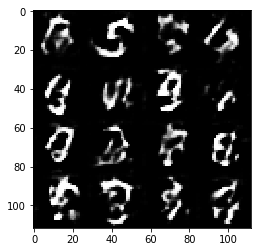

Epoch 1/2... Discriminator Loss: 1.6832... Generator Loss: 1.7284


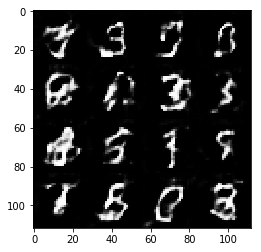

Epoch 1/2... Discriminator Loss: 1.9610... Generator Loss: 0.2316


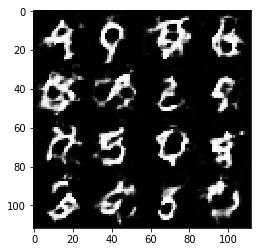

Epoch 1/2... Discriminator Loss: 1.5384... Generator Loss: 0.3878


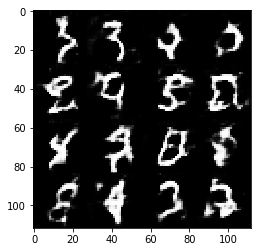

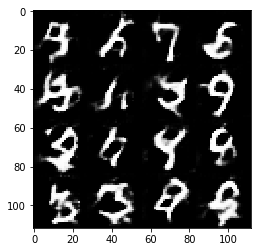

Epoch 2/2... Discriminator Loss: 2.1287... Generator Loss: 0.1608


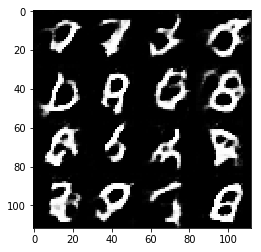

Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.9633


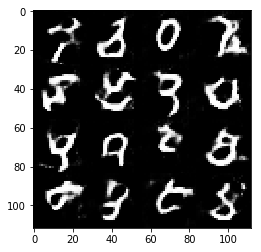

Epoch 2/2... Discriminator Loss: 1.9672... Generator Loss: 0.2112


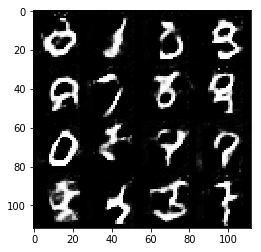

Epoch 2/2... Discriminator Loss: 2.2245... Generator Loss: 0.1894


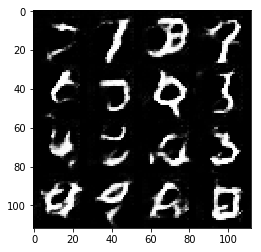

Epoch 2/2... Discriminator Loss: 1.7009... Generator Loss: 0.2830


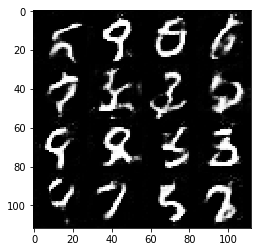

Epoch 2/2... Discriminator Loss: 1.4627... Generator Loss: 0.8007


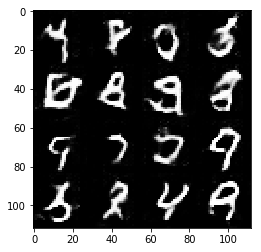

Epoch 2/2... Discriminator Loss: 1.4850... Generator Loss: 0.7571


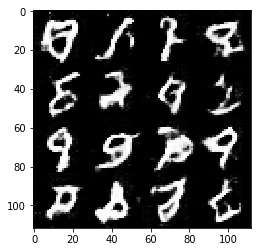

Epoch 2/2... Discriminator Loss: 2.0230... Generator Loss: 0.2255


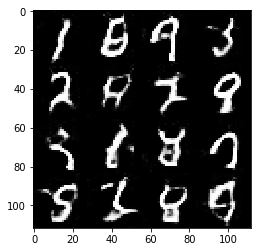

Epoch 2/2... Discriminator Loss: 1.3614... Generator Loss: 0.9876


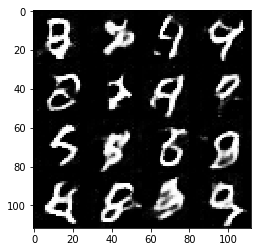

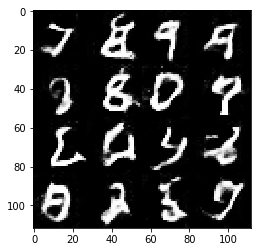

In [12]:
batch_size = 64
z_dim = 200
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, show_every=100, print_every=100)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10... Discriminator Loss: 0.6243... Generator Loss: 2.0695
Epoch 1/10... Discriminator Loss: 4.3701... Generator Loss: 0.2019
Epoch 1/10... Discriminator Loss: 3.3439... Generator Loss: 0.2547
Epoch 1/10... Discriminator Loss: 2.4031... Generator Loss: 1.2882
Epoch 1/10... Discriminator Loss: 3.1151... Generator Loss: 0.1212
Epoch 1/10... Discriminator Loss: 2.2293... Generator Loss: 0.1741
Epoch 1/10... Discriminator Loss: 2.5353... Generator Loss: 2.2589
Epoch 1/10... Discriminator Loss: 3.6822... Generator Loss: 0.0530
Epoch 1/10... Discriminator Loss: 2.6127... Generator Loss: 0.3925
Epoch 1/10... Discriminator Loss: 2.7880... Generator Loss: 1.8401


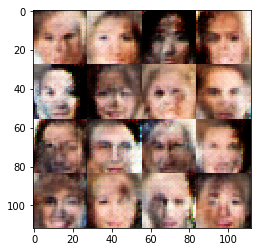

Epoch 1/10... Discriminator Loss: 3.1096... Generator Loss: 0.0856
Epoch 1/10... Discriminator Loss: 2.1127... Generator Loss: 1.4658
Epoch 1/10... Discriminator Loss: 1.7424... Generator Loss: 0.6830
Epoch 1/10... Discriminator Loss: 2.3958... Generator Loss: 0.1860
Epoch 1/10... Discriminator Loss: 2.7890... Generator Loss: 0.1717
Epoch 1/10... Discriminator Loss: 2.2544... Generator Loss: 0.2030
Epoch 1/10... Discriminator Loss: 1.9548... Generator Loss: 1.0943
Epoch 1/10... Discriminator Loss: 2.3652... Generator Loss: 2.0575
Epoch 1/10... Discriminator Loss: 2.0335... Generator Loss: 0.2336
Epoch 1/10... Discriminator Loss: 1.9179... Generator Loss: 0.8112


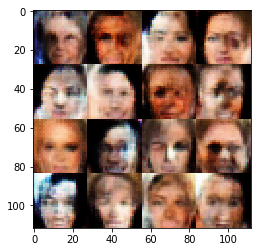

Epoch 1/10... Discriminator Loss: 1.8151... Generator Loss: 0.9761
Epoch 1/10... Discriminator Loss: 1.7261... Generator Loss: 1.1579
Epoch 1/10... Discriminator Loss: 1.9448... Generator Loss: 0.7386
Epoch 1/10... Discriminator Loss: 2.1722... Generator Loss: 1.4703
Epoch 1/10... Discriminator Loss: 1.9516... Generator Loss: 0.9720
Epoch 1/10... Discriminator Loss: 1.9048... Generator Loss: 1.3416
Epoch 1/10... Discriminator Loss: 2.2659... Generator Loss: 0.1965
Epoch 1/10... Discriminator Loss: 1.5746... Generator Loss: 0.8818
Epoch 1/10... Discriminator Loss: 1.6893... Generator Loss: 1.1479
Epoch 1/10... Discriminator Loss: 1.4767... Generator Loss: 1.2398


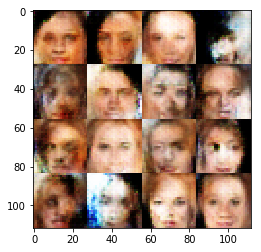

Epoch 1/10... Discriminator Loss: 1.8926... Generator Loss: 0.3738


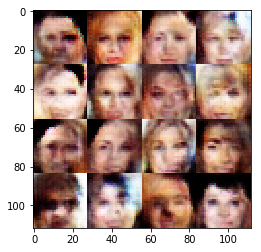

Epoch 2/10... Discriminator Loss: 2.3487... Generator Loss: 0.2765
Epoch 2/10... Discriminator Loss: 1.8277... Generator Loss: 0.3271
Epoch 2/10... Discriminator Loss: 1.6391... Generator Loss: 0.7815
Epoch 2/10... Discriminator Loss: 1.5724... Generator Loss: 0.5852
Epoch 2/10... Discriminator Loss: 1.8527... Generator Loss: 0.7139
Epoch 2/10... Discriminator Loss: 1.8244... Generator Loss: 0.9352
Epoch 2/10... Discriminator Loss: 1.5692... Generator Loss: 0.5708
Epoch 2/10... Discriminator Loss: 1.8784... Generator Loss: 0.2955
Epoch 2/10... Discriminator Loss: 1.6307... Generator Loss: 0.8922


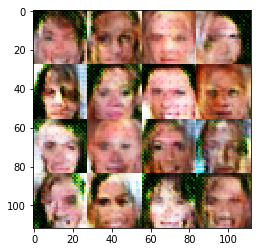

Epoch 2/10... Discriminator Loss: 1.8745... Generator Loss: 1.1596
Epoch 2/10... Discriminator Loss: 1.8992... Generator Loss: 1.5301
Epoch 2/10... Discriminator Loss: 1.6310... Generator Loss: 1.2511
Epoch 2/10... Discriminator Loss: 1.7337... Generator Loss: 0.4125
Epoch 2/10... Discriminator Loss: 1.7016... Generator Loss: 1.0144
Epoch 2/10... Discriminator Loss: 1.6226... Generator Loss: 1.2283
Epoch 2/10... Discriminator Loss: 1.7119... Generator Loss: 0.5476
Epoch 2/10... Discriminator Loss: 1.6152... Generator Loss: 1.0672
Epoch 2/10... Discriminator Loss: 1.5471... Generator Loss: 0.9802
Epoch 2/10... Discriminator Loss: 1.6783... Generator Loss: 0.6044


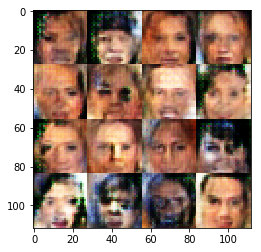

Epoch 2/10... Discriminator Loss: 1.3979... Generator Loss: 0.9959
Epoch 2/10... Discriminator Loss: 1.4136... Generator Loss: 0.7437
Epoch 2/10... Discriminator Loss: 1.4758... Generator Loss: 1.0041
Epoch 2/10... Discriminator Loss: 1.5741... Generator Loss: 0.5131
Epoch 2/10... Discriminator Loss: 1.7481... Generator Loss: 0.8093
Epoch 2/10... Discriminator Loss: 1.5212... Generator Loss: 0.8659
Epoch 2/10... Discriminator Loss: 1.6876... Generator Loss: 0.3777
Epoch 2/10... Discriminator Loss: 1.6073... Generator Loss: 0.5712
Epoch 2/10... Discriminator Loss: 1.6877... Generator Loss: 0.5030
Epoch 2/10... Discriminator Loss: 1.5783... Generator Loss: 0.7432


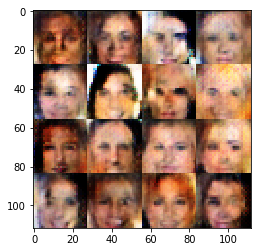

Epoch 2/10... Discriminator Loss: 1.5341... Generator Loss: 0.8231
Epoch 2/10... Discriminator Loss: 1.4120... Generator Loss: 0.6687
Epoch 2/10... Discriminator Loss: 1.4301... Generator Loss: 0.5904


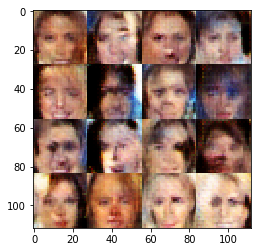

Epoch 3/10... Discriminator Loss: 1.4570... Generator Loss: 0.6169
Epoch 3/10... Discriminator Loss: 1.4847... Generator Loss: 0.8055
Epoch 3/10... Discriminator Loss: 1.7894... Generator Loss: 0.5503
Epoch 3/10... Discriminator Loss: 1.4499... Generator Loss: 0.7642
Epoch 3/10... Discriminator Loss: 1.4317... Generator Loss: 0.5245
Epoch 3/10... Discriminator Loss: 1.3784... Generator Loss: 0.6120
Epoch 3/10... Discriminator Loss: 1.6878... Generator Loss: 0.3320


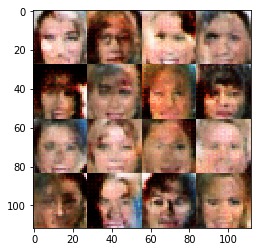

Epoch 3/10... Discriminator Loss: 1.3769... Generator Loss: 0.6010
Epoch 3/10... Discriminator Loss: 1.4263... Generator Loss: 0.6075
Epoch 3/10... Discriminator Loss: 1.4678... Generator Loss: 0.5769
Epoch 3/10... Discriminator Loss: 1.4776... Generator Loss: 0.6028
Epoch 3/10... Discriminator Loss: 1.5027... Generator Loss: 0.4367
Epoch 3/10... Discriminator Loss: 1.7070... Generator Loss: 0.9327
Epoch 3/10... Discriminator Loss: 1.4378... Generator Loss: 0.5163
Epoch 3/10... Discriminator Loss: 1.3861... Generator Loss: 0.8655
Epoch 3/10... Discriminator Loss: 1.5229... Generator Loss: 0.5485
Epoch 3/10... Discriminator Loss: 1.4219... Generator Loss: 0.6419


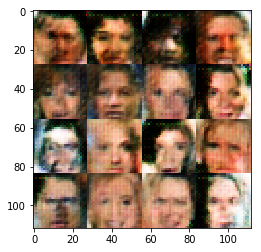

Epoch 3/10... Discriminator Loss: 1.5115... Generator Loss: 0.5595
Epoch 3/10... Discriminator Loss: 1.4825... Generator Loss: 0.4808
Epoch 3/10... Discriminator Loss: 1.5025... Generator Loss: 0.8978
Epoch 3/10... Discriminator Loss: 1.4628... Generator Loss: 0.6170
Epoch 3/10... Discriminator Loss: 1.5081... Generator Loss: 0.6184
Epoch 3/10... Discriminator Loss: 1.5688... Generator Loss: 0.5128
Epoch 3/10... Discriminator Loss: 1.6091... Generator Loss: 0.4944
Epoch 3/10... Discriminator Loss: 1.4648... Generator Loss: 0.4738
Epoch 3/10... Discriminator Loss: 1.5721... Generator Loss: 0.4824
Epoch 3/10... Discriminator Loss: 1.5065... Generator Loss: 0.5963


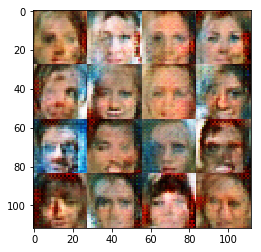

Epoch 3/10... Discriminator Loss: 1.5190... Generator Loss: 0.7039
Epoch 3/10... Discriminator Loss: 1.5226... Generator Loss: 0.5377
Epoch 3/10... Discriminator Loss: 1.6270... Generator Loss: 0.4158
Epoch 3/10... Discriminator Loss: 1.4399... Generator Loss: 0.6628


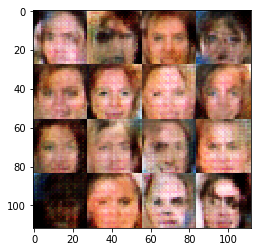

Epoch 4/10... Discriminator Loss: 1.4658... Generator Loss: 0.9360
Epoch 4/10... Discriminator Loss: 1.4160... Generator Loss: 0.6226
Epoch 4/10... Discriminator Loss: 1.4747... Generator Loss: 0.7317
Epoch 4/10... Discriminator Loss: 1.5493... Generator Loss: 0.4372
Epoch 4/10... Discriminator Loss: 1.5258... Generator Loss: 0.4434
Epoch 4/10... Discriminator Loss: 1.4523... Generator Loss: 0.8116


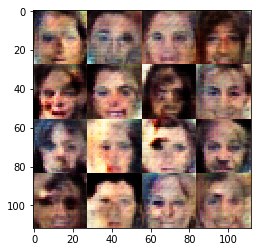

Epoch 4/10... Discriminator Loss: 1.3823... Generator Loss: 0.7605
Epoch 4/10... Discriminator Loss: 1.3601... Generator Loss: 0.6768
Epoch 4/10... Discriminator Loss: 1.4470... Generator Loss: 0.6154
Epoch 4/10... Discriminator Loss: 1.4983... Generator Loss: 0.4815
Epoch 4/10... Discriminator Loss: 1.4597... Generator Loss: 0.4613
Epoch 4/10... Discriminator Loss: 1.5340... Generator Loss: 0.6753
Epoch 4/10... Discriminator Loss: 1.4278... Generator Loss: 0.5836
Epoch 4/10... Discriminator Loss: 1.4391... Generator Loss: 0.9919
Epoch 4/10... Discriminator Loss: 1.4189... Generator Loss: 0.7929
Epoch 4/10... Discriminator Loss: 1.5101... Generator Loss: 0.8968


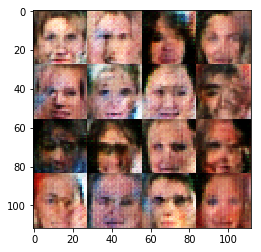

Epoch 4/10... Discriminator Loss: 1.3796... Generator Loss: 0.8500
Epoch 4/10... Discriminator Loss: 1.5178... Generator Loss: 0.6719
Epoch 4/10... Discriminator Loss: 1.4263... Generator Loss: 0.4616
Epoch 4/10... Discriminator Loss: 1.4255... Generator Loss: 0.5639
Epoch 4/10... Discriminator Loss: 1.4476... Generator Loss: 0.7617
Epoch 4/10... Discriminator Loss: 1.4167... Generator Loss: 0.5758
Epoch 4/10... Discriminator Loss: 1.4891... Generator Loss: 0.4591
Epoch 4/10... Discriminator Loss: 1.4242... Generator Loss: 0.7706
Epoch 4/10... Discriminator Loss: 1.4704... Generator Loss: 0.5233
Epoch 4/10... Discriminator Loss: 1.4277... Generator Loss: 0.7604


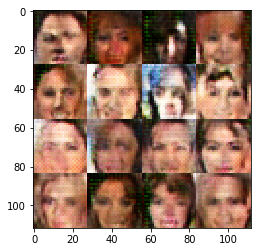

Epoch 4/10... Discriminator Loss: 1.4214... Generator Loss: 0.6428
Epoch 4/10... Discriminator Loss: 1.4231... Generator Loss: 0.6412
Epoch 4/10... Discriminator Loss: 1.4778... Generator Loss: 1.0830
Epoch 4/10... Discriminator Loss: 1.4861... Generator Loss: 0.4151
Epoch 4/10... Discriminator Loss: 1.3721... Generator Loss: 0.6406
Epoch 4/10... Discriminator Loss: 1.4171... Generator Loss: 0.6401


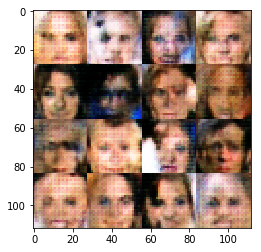

Epoch 5/10... Discriminator Loss: 1.4487... Generator Loss: 0.7810
Epoch 5/10... Discriminator Loss: 1.4113... Generator Loss: 0.8355
Epoch 5/10... Discriminator Loss: 1.4650... Generator Loss: 0.8100
Epoch 5/10... Discriminator Loss: 1.3938... Generator Loss: 0.7904


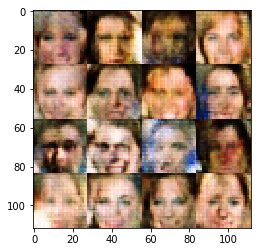

Epoch 5/10... Discriminator Loss: 1.3562... Generator Loss: 0.6814
Epoch 5/10... Discriminator Loss: 1.4192... Generator Loss: 0.5664
Epoch 5/10... Discriminator Loss: 1.4310... Generator Loss: 0.6623
Epoch 5/10... Discriminator Loss: 1.4601... Generator Loss: 0.5134
Epoch 5/10... Discriminator Loss: 1.3850... Generator Loss: 0.7471
Epoch 5/10... Discriminator Loss: 1.4204... Generator Loss: 0.7216
Epoch 5/10... Discriminator Loss: 1.4309... Generator Loss: 0.7289
Epoch 5/10... Discriminator Loss: 1.3961... Generator Loss: 0.6537
Epoch 5/10... Discriminator Loss: 1.4006... Generator Loss: 0.7329
Epoch 5/10... Discriminator Loss: 1.3848... Generator Loss: 0.7970


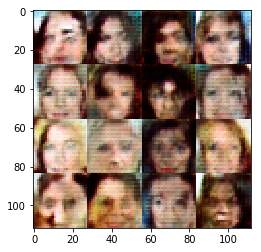

Epoch 5/10... Discriminator Loss: 1.3960... Generator Loss: 0.6951
Epoch 5/10... Discriminator Loss: 1.4581... Generator Loss: 0.7166
Epoch 5/10... Discriminator Loss: 1.4272... Generator Loss: 0.6945
Epoch 5/10... Discriminator Loss: 1.4870... Generator Loss: 1.0159
Epoch 5/10... Discriminator Loss: 1.4005... Generator Loss: 0.6549
Epoch 5/10... Discriminator Loss: 1.3799... Generator Loss: 0.7364
Epoch 5/10... Discriminator Loss: 1.4299... Generator Loss: 0.7741
Epoch 5/10... Discriminator Loss: 1.4014... Generator Loss: 0.7328
Epoch 5/10... Discriminator Loss: 1.3864... Generator Loss: 0.6865
Epoch 5/10... Discriminator Loss: 1.3817... Generator Loss: 0.6505


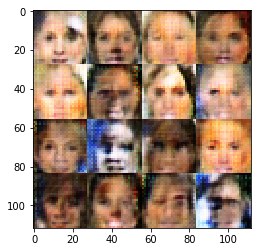

Epoch 5/10... Discriminator Loss: 1.3865... Generator Loss: 0.7614
Epoch 5/10... Discriminator Loss: 1.4062... Generator Loss: 0.6905
Epoch 5/10... Discriminator Loss: 1.3899... Generator Loss: 0.6845
Epoch 5/10... Discriminator Loss: 1.4683... Generator Loss: 0.9620
Epoch 5/10... Discriminator Loss: 1.4010... Generator Loss: 0.6644
Epoch 5/10... Discriminator Loss: 1.4722... Generator Loss: 0.9830
Epoch 5/10... Discriminator Loss: 1.3910... Generator Loss: 0.8086
Epoch 5/10... Discriminator Loss: 1.3934... Generator Loss: 0.6549


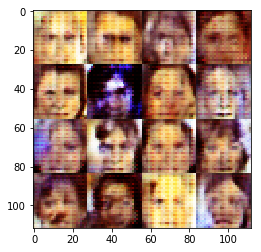

Epoch 6/10... Discriminator Loss: 1.3963... Generator Loss: 0.6871
Epoch 6/10... Discriminator Loss: 1.3826... Generator Loss: 0.6916


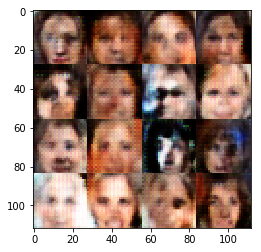

Epoch 6/10... Discriminator Loss: 1.3925... Generator Loss: 0.6586
Epoch 6/10... Discriminator Loss: 1.3863... Generator Loss: 0.7177
Epoch 6/10... Discriminator Loss: 1.4074... Generator Loss: 0.6997
Epoch 6/10... Discriminator Loss: 1.3985... Generator Loss: 0.6535
Epoch 6/10... Discriminator Loss: 1.3805... Generator Loss: 0.6844
Epoch 6/10... Discriminator Loss: 1.3893... Generator Loss: 0.6101
Epoch 6/10... Discriminator Loss: 1.3935... Generator Loss: 0.7271
Epoch 6/10... Discriminator Loss: 1.4140... Generator Loss: 0.5818
Epoch 6/10... Discriminator Loss: 1.3829... Generator Loss: 0.7138
Epoch 6/10... Discriminator Loss: 1.4150... Generator Loss: 0.6416


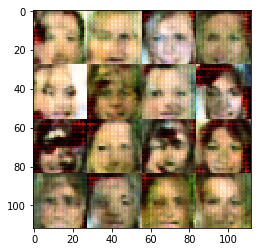

Epoch 6/10... Discriminator Loss: 1.4011... Generator Loss: 0.6898
Epoch 6/10... Discriminator Loss: 1.3897... Generator Loss: 0.7017
Epoch 6/10... Discriminator Loss: 1.4362... Generator Loss: 0.5828
Epoch 6/10... Discriminator Loss: 1.3785... Generator Loss: 0.5968
Epoch 6/10... Discriminator Loss: 1.3854... Generator Loss: 0.6907
Epoch 6/10... Discriminator Loss: 1.3820... Generator Loss: 0.6896
Epoch 6/10... Discriminator Loss: 1.3688... Generator Loss: 0.6813
Epoch 6/10... Discriminator Loss: 1.4070... Generator Loss: 0.6706
Epoch 6/10... Discriminator Loss: 1.4136... Generator Loss: 0.6163
Epoch 6/10... Discriminator Loss: 1.4144... Generator Loss: 0.7115


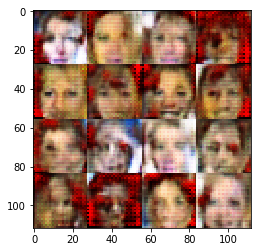

Epoch 6/10... Discriminator Loss: 1.3836... Generator Loss: 0.6931
Epoch 6/10... Discriminator Loss: 1.3934... Generator Loss: 0.6880
Epoch 6/10... Discriminator Loss: 1.3887... Generator Loss: 0.6716
Epoch 6/10... Discriminator Loss: 1.3903... Generator Loss: 0.6614
Epoch 6/10... Discriminator Loss: 1.3934... Generator Loss: 0.7295
Epoch 6/10... Discriminator Loss: 1.3893... Generator Loss: 0.6869
Epoch 6/10... Discriminator Loss: 1.4194... Generator Loss: 0.6575
Epoch 6/10... Discriminator Loss: 1.4461... Generator Loss: 0.7891
Epoch 6/10... Discriminator Loss: 1.3882... Generator Loss: 0.6525


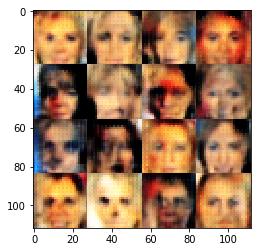

Epoch 7/10... Discriminator Loss: 1.3961... Generator Loss: 0.7023


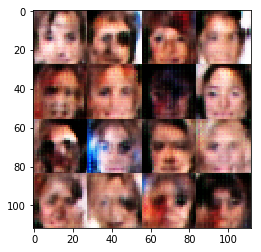

Epoch 7/10... Discriminator Loss: 1.3732... Generator Loss: 0.7023
Epoch 7/10... Discriminator Loss: 1.3764... Generator Loss: 0.6850
Epoch 7/10... Discriminator Loss: 1.3900... Generator Loss: 0.6799
Epoch 7/10... Discriminator Loss: 1.5180... Generator Loss: 1.0902
Epoch 7/10... Discriminator Loss: 1.4070... Generator Loss: 0.6574
Epoch 7/10... Discriminator Loss: 1.4071... Generator Loss: 0.7027
Epoch 7/10... Discriminator Loss: 1.3966... Generator Loss: 0.6597
Epoch 7/10... Discriminator Loss: 1.3875... Generator Loss: 0.6662
Epoch 7/10... Discriminator Loss: 1.4362... Generator Loss: 0.6602
Epoch 7/10... Discriminator Loss: 1.3908... Generator Loss: 0.6126


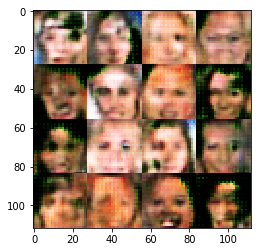

Epoch 7/10... Discriminator Loss: 1.4730... Generator Loss: 0.8811
Epoch 7/10... Discriminator Loss: 1.3754... Generator Loss: 0.6664
Epoch 7/10... Discriminator Loss: 1.4105... Generator Loss: 0.6814
Epoch 7/10... Discriminator Loss: 1.4548... Generator Loss: 0.8395
Epoch 7/10... Discriminator Loss: 1.4293... Generator Loss: 0.7623
Epoch 7/10... Discriminator Loss: 1.4203... Generator Loss: 0.7670
Epoch 7/10... Discriminator Loss: 1.3705... Generator Loss: 0.7027
Epoch 7/10... Discriminator Loss: 1.3789... Generator Loss: 0.7195
Epoch 7/10... Discriminator Loss: 1.3863... Generator Loss: 0.7049
Epoch 7/10... Discriminator Loss: 1.4147... Generator Loss: 0.6969


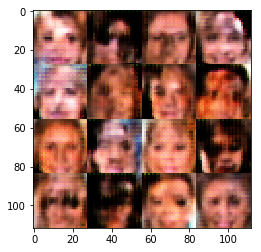

Epoch 7/10... Discriminator Loss: 1.3566... Generator Loss: 0.6815
Epoch 7/10... Discriminator Loss: 1.3785... Generator Loss: 0.6842
Epoch 7/10... Discriminator Loss: 1.3910... Generator Loss: 0.6775
Epoch 7/10... Discriminator Loss: 1.3758... Generator Loss: 0.6923
Epoch 7/10... Discriminator Loss: 1.4708... Generator Loss: 0.8822
Epoch 7/10... Discriminator Loss: 1.4035... Generator Loss: 0.7043
Epoch 7/10... Discriminator Loss: 1.4010... Generator Loss: 0.6721
Epoch 7/10... Discriminator Loss: 1.4307... Generator Loss: 0.5258
Epoch 7/10... Discriminator Loss: 1.3793... Generator Loss: 0.7015
Epoch 7/10... Discriminator Loss: 1.3986... Generator Loss: 0.7647


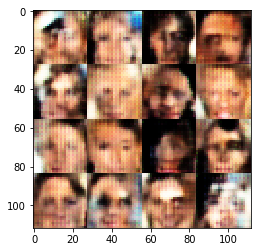

Epoch 7/10... Discriminator Loss: 1.3845... Generator Loss: 0.6793


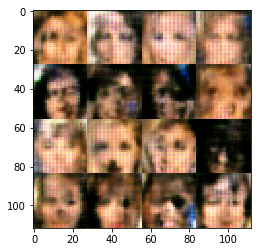

Epoch 8/10... Discriminator Loss: 1.4064... Generator Loss: 0.6850
Epoch 8/10... Discriminator Loss: 1.3905... Generator Loss: 0.6813
Epoch 8/10... Discriminator Loss: 1.3615... Generator Loss: 0.7117
Epoch 8/10... Discriminator Loss: 1.4060... Generator Loss: 0.6448
Epoch 8/10... Discriminator Loss: 1.4275... Generator Loss: 0.6523
Epoch 8/10... Discriminator Loss: 1.3820... Generator Loss: 0.6874
Epoch 8/10... Discriminator Loss: 1.4068... Generator Loss: 0.6165
Epoch 8/10... Discriminator Loss: 1.4220... Generator Loss: 0.6517
Epoch 8/10... Discriminator Loss: 1.4392... Generator Loss: 0.8703


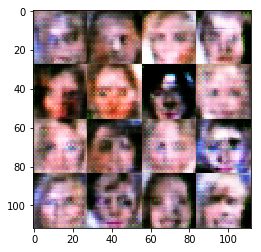

Epoch 8/10... Discriminator Loss: 1.4259... Generator Loss: 0.6642
Epoch 8/10... Discriminator Loss: 1.4821... Generator Loss: 0.5247
Epoch 8/10... Discriminator Loss: 1.4148... Generator Loss: 0.6778
Epoch 8/10... Discriminator Loss: 1.3879... Generator Loss: 0.6767
Epoch 8/10... Discriminator Loss: 1.4325... Generator Loss: 0.6842
Epoch 8/10... Discriminator Loss: 1.4498... Generator Loss: 0.6625
Epoch 8/10... Discriminator Loss: 1.3986... Generator Loss: 0.7314
Epoch 8/10... Discriminator Loss: 1.4123... Generator Loss: 0.7296
Epoch 8/10... Discriminator Loss: 1.3940... Generator Loss: 0.6915
Epoch 8/10... Discriminator Loss: 1.3943... Generator Loss: 0.6780


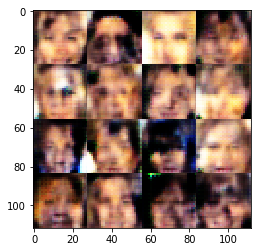

Epoch 8/10... Discriminator Loss: 1.3627... Generator Loss: 0.7276
Epoch 8/10... Discriminator Loss: 1.3064... Generator Loss: 0.6293
Epoch 8/10... Discriminator Loss: 1.3722... Generator Loss: 0.7101
Epoch 8/10... Discriminator Loss: 1.4178... Generator Loss: 0.6416
Epoch 8/10... Discriminator Loss: 1.3979... Generator Loss: 0.6651
Epoch 8/10... Discriminator Loss: 1.3845... Generator Loss: 0.7114
Epoch 8/10... Discriminator Loss: 1.3854... Generator Loss: 0.6911
Epoch 8/10... Discriminator Loss: 1.3864... Generator Loss: 0.7097
Epoch 8/10... Discriminator Loss: 1.3610... Generator Loss: 0.7014
Epoch 8/10... Discriminator Loss: 1.3901... Generator Loss: 0.6529


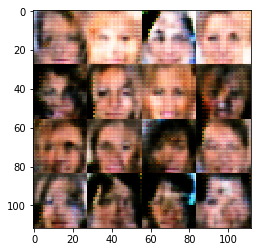

Epoch 8/10... Discriminator Loss: 1.4052... Generator Loss: 0.6740
Epoch 8/10... Discriminator Loss: 1.3844... Generator Loss: 0.6865
Epoch 8/10... Discriminator Loss: 1.4013... Generator Loss: 0.6763


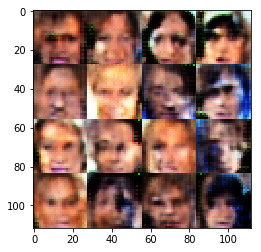

Epoch 9/10... Discriminator Loss: 1.3891... Generator Loss: 0.6803
Epoch 9/10... Discriminator Loss: 1.3798... Generator Loss: 0.7063
Epoch 9/10... Discriminator Loss: 1.3907... Generator Loss: 0.6849
Epoch 9/10... Discriminator Loss: 1.4242... Generator Loss: 0.6425
Epoch 9/10... Discriminator Loss: 1.3909... Generator Loss: 0.6865
Epoch 9/10... Discriminator Loss: 1.3987... Generator Loss: 0.6919
Epoch 9/10... Discriminator Loss: 1.4119... Generator Loss: 0.7087


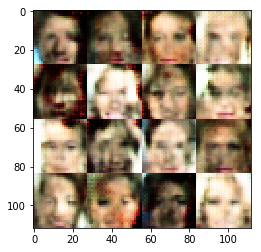

Epoch 9/10... Discriminator Loss: 1.3756... Generator Loss: 0.7355
Epoch 9/10... Discriminator Loss: 1.3465... Generator Loss: 0.7258
Epoch 9/10... Discriminator Loss: 1.4153... Generator Loss: 0.6284
Epoch 9/10... Discriminator Loss: 1.4100... Generator Loss: 0.7249
Epoch 9/10... Discriminator Loss: 1.3648... Generator Loss: 0.7229
Epoch 9/10... Discriminator Loss: 1.4027... Generator Loss: 0.6911
Epoch 9/10... Discriminator Loss: 1.4048... Generator Loss: 0.6321
Epoch 9/10... Discriminator Loss: 1.3684... Generator Loss: 0.7452
Epoch 9/10... Discriminator Loss: 1.3795... Generator Loss: 0.6974
Epoch 9/10... Discriminator Loss: 1.4138... Generator Loss: 0.6845


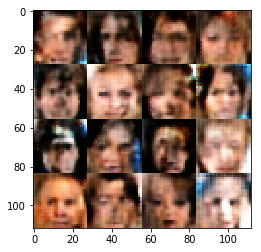

Epoch 9/10... Discriminator Loss: 1.3814... Generator Loss: 0.6884
Epoch 9/10... Discriminator Loss: 1.4066... Generator Loss: 0.6534
Epoch 9/10... Discriminator Loss: 1.4208... Generator Loss: 0.6809
Epoch 9/10... Discriminator Loss: 1.3888... Generator Loss: 0.5890
Epoch 9/10... Discriminator Loss: 1.4125... Generator Loss: 0.7058
Epoch 9/10... Discriminator Loss: 1.5023... Generator Loss: 0.5019
Epoch 9/10... Discriminator Loss: 1.4022... Generator Loss: 0.6901
Epoch 9/10... Discriminator Loss: 1.3899... Generator Loss: 0.7332
Epoch 9/10... Discriminator Loss: 1.3907... Generator Loss: 0.6769
Epoch 9/10... Discriminator Loss: 1.3994... Generator Loss: 0.6756


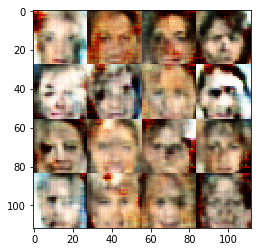

Epoch 9/10... Discriminator Loss: 1.3487... Generator Loss: 0.7143
Epoch 9/10... Discriminator Loss: 1.4220... Generator Loss: 0.7124
Epoch 9/10... Discriminator Loss: 1.3993... Generator Loss: 0.6830
Epoch 9/10... Discriminator Loss: 1.3646... Generator Loss: 0.6248


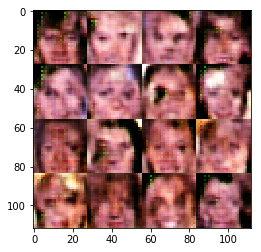

Epoch 10/10... Discriminator Loss: 1.3817... Generator Loss: 0.7132
Epoch 10/10... Discriminator Loss: 1.4404... Generator Loss: 0.6810
Epoch 10/10... Discriminator Loss: 1.3990... Generator Loss: 0.7071
Epoch 10/10... Discriminator Loss: 1.4063... Generator Loss: 0.6784
Epoch 10/10... Discriminator Loss: 1.3825... Generator Loss: 0.6761
Epoch 10/10... Discriminator Loss: 1.3652... Generator Loss: 0.6885


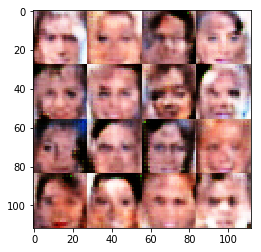

Epoch 10/10... Discriminator Loss: 1.3810... Generator Loss: 0.6599
Epoch 10/10... Discriminator Loss: 1.3893... Generator Loss: 0.7238
Epoch 10/10... Discriminator Loss: 1.3514... Generator Loss: 0.7010
Epoch 10/10... Discriminator Loss: 1.3739... Generator Loss: 0.7016
Epoch 10/10... Discriminator Loss: 1.3809... Generator Loss: 0.6905
Epoch 10/10... Discriminator Loss: 1.4014... Generator Loss: 0.6868
Epoch 10/10... Discriminator Loss: 1.4028... Generator Loss: 0.7156
Epoch 10/10... Discriminator Loss: 1.3756... Generator Loss: 0.7550
Epoch 10/10... Discriminator Loss: 1.3778... Generator Loss: 0.6931
Epoch 10/10... Discriminator Loss: 1.3904... Generator Loss: 0.6754


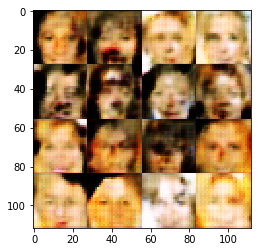

Epoch 10/10... Discriminator Loss: 1.3606... Generator Loss: 0.7078
Epoch 10/10... Discriminator Loss: 1.3374... Generator Loss: 0.7349
Epoch 10/10... Discriminator Loss: 1.4453... Generator Loss: 0.6192
Epoch 10/10... Discriminator Loss: 1.3793... Generator Loss: 0.7388
Epoch 10/10... Discriminator Loss: 1.3936... Generator Loss: 0.7087
Epoch 10/10... Discriminator Loss: 1.3932... Generator Loss: 0.7470
Epoch 10/10... Discriminator Loss: 1.3661... Generator Loss: 0.7070
Epoch 10/10... Discriminator Loss: 1.3858... Generator Loss: 0.6789
Epoch 10/10... Discriminator Loss: 1.3925... Generator Loss: 0.7330
Epoch 10/10... Discriminator Loss: 1.3820... Generator Loss: 0.7024


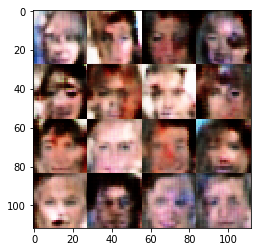

Epoch 10/10... Discriminator Loss: 1.4062... Generator Loss: 0.6382
Epoch 10/10... Discriminator Loss: 1.4021... Generator Loss: 0.7292
Epoch 10/10... Discriminator Loss: 1.3768... Generator Loss: 0.7120
Epoch 10/10... Discriminator Loss: 1.3695... Generator Loss: 0.6950
Epoch 10/10... Discriminator Loss: 1.4002... Generator Loss: 0.6653
Epoch 10/10... Discriminator Loss: 1.3932... Generator Loss: 0.7237


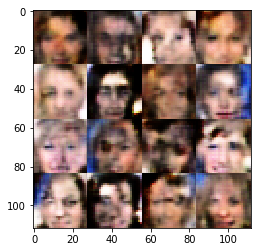

In [13]:
batch_size = 64
z_dim = 200
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, show_every=1000, print_every=100)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.